In [1]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
from pandas.plotting import autocorrelation_plot,lag_plot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import datetime as dt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
import warnings
from bokeh.plotting import figure, output_notebook, show
from time import time

In [2]:
t=pd.read_csv("Tracesip.csv")
t['date']=pd.to_datetime(t['date'])
t.dtypes

Unnamed: 0             int64
TC                    object
date          datetime64[ns]
lbl                   object
datedelta              int64
dtype: object

In [3]:
t

,Unnamed: 0,TC,date,lbl,datedelta
0,0,TNST101TC101,2012-03-30,f,0
1,1,TNST101TC101,2012-03-30,f,0
2,2,TNST101TC101,2012-03-31,f,1
3,3,TNST101TC101,2012-04-19,f,19
4,4,TNST101TC101,2012-04-20,f,1
...,...,...,...,...,...
77074,77074,TNST345TC286,2019-11-16,f,0
77075,77075,TNST345TC293,2019-12-09,f,185
77076,77076,TNST345TC293,2019-12-09,f,0
77077,77077,TNST345TC417,2019-06-11,f,1669


In [4]:
sc = 'TNST101TC101'
t11 = t[t['TC'] == sc]
t11=t11.drop(['Unnamed: 0','lbl','TC'],axis=1) 
t11

,date,datedelta
0,2012-03-30,0
1,2012-03-30,0
2,2012-03-31,1
3,2012-04-19,19
4,2012-04-20,1
...,...,...
240,2019-11-08,11
241,2019-11-14,6
242,2019-11-14,0
243,2019-11-24,1


In [5]:
#try:
        #for i in t.index[0:]:
            #if  (t.at[i+1, 'TC'] == t.at[i, 'TC']):
                #t.at[i+1, 'datedelta2'] = t.at[i+1, 'date'] - t.at[i, 'date']
         #   else : i+=1
                    
#except KeyError:
 #       print("last key parsed")

In [6]:
t11['adate']=t11['datedelta'].shift(-1)   #date and number of days after which next error in a TNST101TC101 can occur 

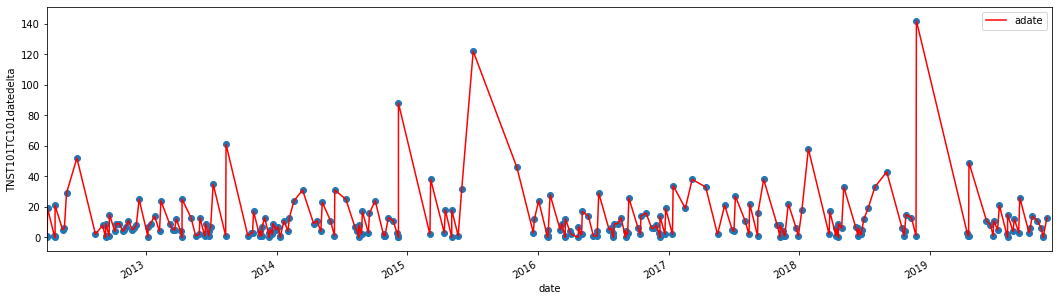

In [7]:
plt.rcParams['figure.figsize'] = [18, 5]  
t11.plot(kind='line',x='date',y='adate',color='red')
plt.xlabel('date')
plt.ylabel('TNST101TC101datedelta')
plt.scatter(x=t11['date'],y=t11['adate'])  #more nested datapoints in plot= more errors occuring frequently

In [8]:
t11.datedelta.mean()
t111=t11.copy()
t111=t111.drop(['datedelta'],axis=1)
t111

,date,adate
0,2012-03-30,0.0
1,2012-03-30,1.0
2,2012-03-31,19.0
3,2012-04-19,1.0
4,2012-04-20,1.0
...,...,...
240,2019-11-08,6.0
241,2019-11-14,0.0
242,2019-11-14,1.0
243,2019-11-24,13.0


In [9]:
df_rs = t111.set_index('date').resample('D').mean().interpolate('linear').round(1) #resample according to Days and linear inetrpolate and round values
df_rs

,adate
date,
2012-03-30,0.5
2012-03-31,19.0
2012-04-01,18.1
2012-04-02,17.1
2012-04-03,16.2
...,...
2019-12-03,13.0
2019-12-04,13.0
2019-12-05,13.0


In [10]:
#bokeh library used here , plot will be shown in different tab
p = figure(x_axis_type="datetime", width=800, height=500)

p.title.text = "adate vs. Date Time (linear interpolated to 1D)"
p.xaxis.axis_label = 'Date Time (linear interpolated to to 1D)'
p.yaxis.axis_label = 'adate(next probable occurance of failure)'

# orig data
p.circle(t111['date'], t111['adate'], color='red', size=10)

# oversampled data
p.circle(df_rs.index, df_rs['adate'])
p.line(df_rs.index, df_rs['adate'])

show(p)

In [11]:
X = df_rs.iloc[:,0].values
X

array([ 0.5, 19. , 18.1, ..., 13. , 13. , 13. ])

In [12]:
result=adfuller(X)
pd.DataFrame(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.453993
p-value: 0.000238
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [13]:
df_rs            #has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.
df_rs.to_csv("df_rs.csv")

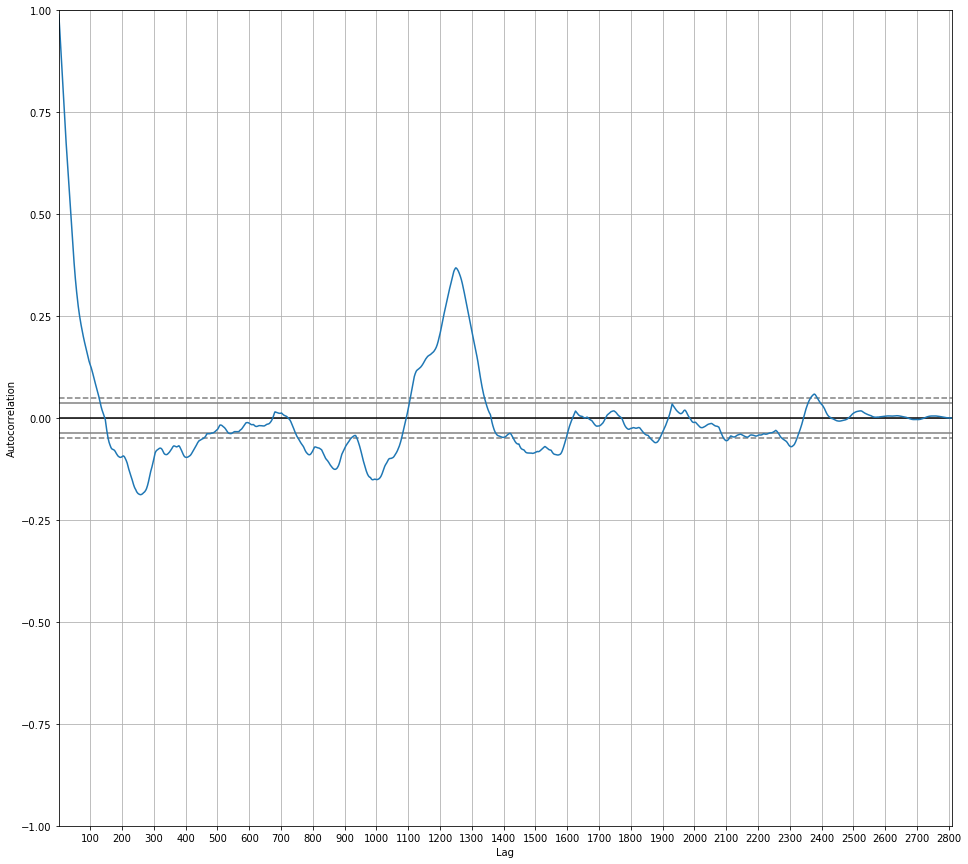

In [14]:
plt.rcParams['figure.figsize'] = [16 ,15]  
ax=autocorrelation_plot(df_rs) 
plt.savefig('autocorrplot.png')   #there is a positive correlation with the first 150 lags that is perhaps significant for the first 120-130 lags.
ax.xaxis.set_major_locator(plt.MaxNLocator(30)) #dashed line is 99% confidence band
plt.show()

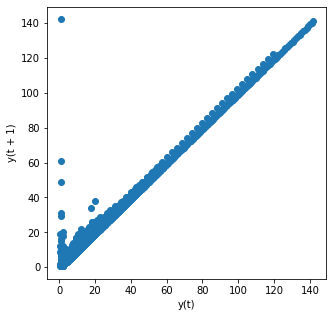

In [15]:
plt.rcParams['figure.figsize'] = [5, 5]  
lag_plot(df_rs)  #shows our Data has High Autocorrelation
plt.savefig('/home/devarshi/Desktop/lagplot.png')

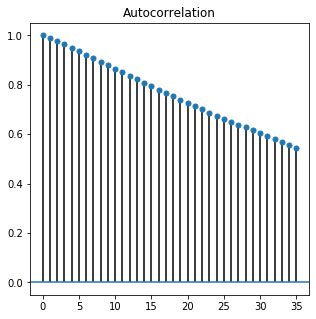

In [16]:
import pmdarima as pm
pm.plot_acf(df_rs)

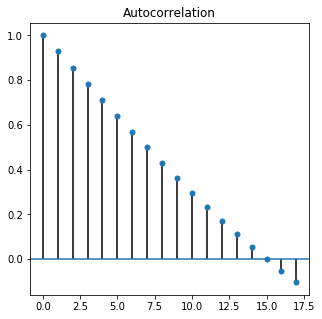

In [17]:
import pmdarima as pm
# Plot an auto-correlation:
pm.plot_acf(pm.acf(X))

In [18]:
# fit stepwise auto-ARIMA
stepwise_fit = pm.auto_arima(df_rs, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=False,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=14983.248, BIC=15007.009, Time=0.444 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=15012.135, BIC=15024.016, Time=0.044 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=14986.692, BIC=15004.513, Time=0.177 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=14988.730, BIC=15006.550, Time=0.177 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=15010.140, BIC=15016.080, Time=0.036 seconds
Fit ARIMA: (2, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=14985.141, BIC=15014.843, Time=0.630 seconds
Fit ARIMA: (1, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=14985.140, BIC=15014.841, Time=0.878 seconds
Fit ARIMA: (0, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=14985.857, BIC=15009.618, Time=0.402 seconds
Fit ARIMA: (2, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=14984.779, BIC=15008.539, Time=0.311 seconds
Fit ARIMA: (2, 1, 2)x(0, 0, 0, 0) (constant=True); AIC=1

In [19]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2809
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -7487.624
Date:                Wed, 19 Feb 2020   AIC                          14983.248
Time:                        14:37:09   BIC                          15007.009
Sample:                             0   HQIC                         14991.824
                               - 2809                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0027      0.075      0.036      0.971      -0.144       0.149
ar.L1          0.5262      0.120      4.389      0.000       0.291       0.761
ma.L1         -0.4335      0.121     -3.590      0.000      -0.670      -0.197
sigma2        12.1239      0.030    409.019      0.000      12.066      12.182
===================================================================================
Ljung-Box (Q):                        3.46   Jarque-Bera (JB):         119326278.72
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.77   Skew:                            27.29
Prob(H) (two-sided):                  0.00   Kurtosis:                      1011.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
df_rs.values,X

(array([[ 0.5],
        [19. ],
        [18.1],
        ...,
        [13. ],
        [13. ],
        [13. ]]), array([ 0.5, 19. , 18.1, ..., 13. , 13. , 13. ]))

In [21]:
size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [34]:
X

array([ 0.5, 19. , 18.1, ..., 13. , 13. , 13. ])

In [22]:
len(test),len(train)

(1405, 1404)

In [23]:
#walk forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)  # forecasted predictions on previous history=train step
    
    obs = test[t]
    history.append(obs)          #history now contains next data point
print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

/home/devarshi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=13.004664, expected=13.000000
Test MSE: 19.088


In [24]:
len(history),len(predictions)

(2809, 1405)

In [33]:
output

(array([13.00466448]),
 array([3.48594758]),
 array([[ 6.17233277, 19.83699619]]))

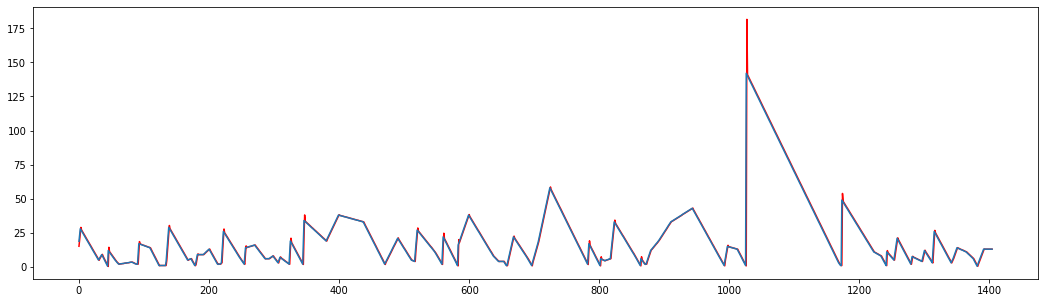

In [32]:
# plot
plt.rcParams['figure.figsize'] = [18, 5] 
pyplot.plot(predictions, color='red')
pyplot.plot(test)

                              ARMA Model Results                              
Dep. Variable:                  adate   No. Observations:                 2809
Model:                     ARMA(1, 0)   Log Likelihood               -7501.230
Method:                       css-mle   S.D. of innovations              3.493
Date:                Wed, 19 Feb 2020   AIC                          15008.460
Time:                        14:40:55   BIC                          15026.282
Sample:                    03-30-2012   HQIC                         15014.892
                         - 12-07-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          21.1059      6.151      3.431      0.001       9.049      33.162
ar.L1.adate     0.9896      0.003    374.435      0.000       0.984       0.995
                                    Roots       

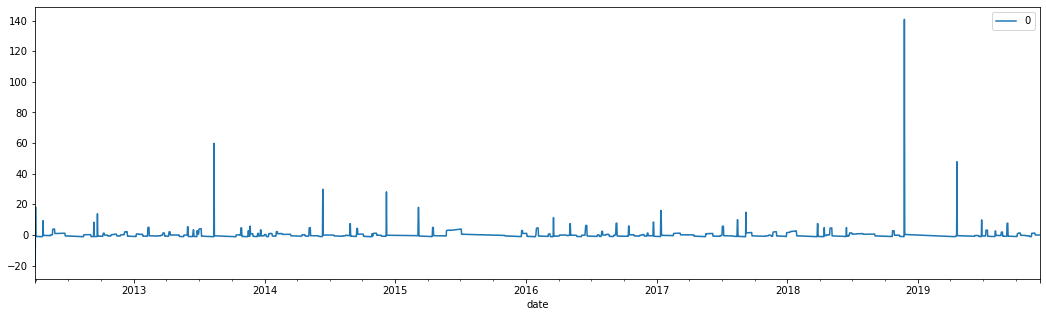

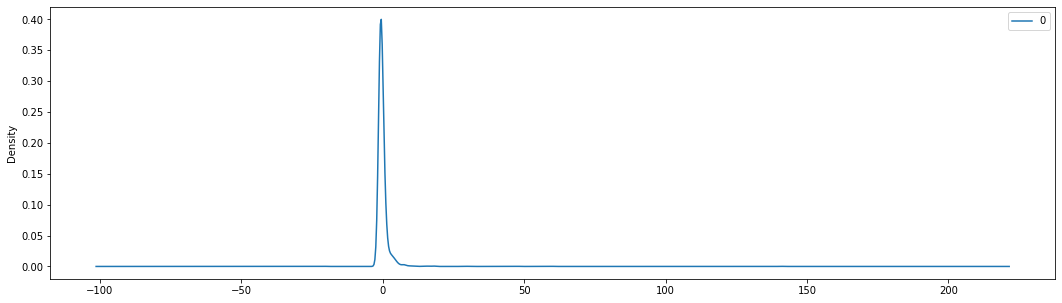

                 0
count  2809.000000
mean      0.007257
std       3.514874
min     -20.605880
25%      -0.885141
50%      -0.583065
75%       0.045986
max     140.791390


In [28]:
#fit model and find residual errors (expected-predicted)
model = ARIMA(df_rs, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
plt.rcParams['figure.figsize'] = [18, 5]  
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# the residual plot suggests that there is still be some trend information not captured by the model.
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())    #results show that there is a bias in the prediction (a non-zero mean in the residuals)

In [ ]:
# evaluate parameters
#p_values = [0, 1, 2, 4, 6, 8, 10]
#d_values = range(0, 3)
#q_values = range(0, 3)
#warnings.filterwarnings("ignore")
#evaluate_models(X, p_values, d_values, q_values)

In [ ]:
# walk-forward validation
for t in range(len(test)):
	# fit model
	model = ARIMA(history, order=(4,1,0))
	model_fit = model.fit()
	# one step forecast
	yhat = model_fit.forecast()[0]
	# store forecast and ob
	predictions.append(yhat)
	history.append(test[t])
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
#The solver parameter specifies the numerical optimization method to fit the coefficients to the data.

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 


In [ ]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from time import time
# solvers
solvers = ['lbfgs', 'bfgs', 'newton', 'nm', 'cg', 'ncg', 'powell']
scores = []
times = []
for solver in solvers:
	start_time = time()
	history = [x for x in train]
	predictions = list()
	# walk-forward validation
	for t in range(len(test)):
		# fit model
		model = ARIMA(history, order=(1,0,0))
		model_fit = model.fit(disp=False, solver=solver)
		# one step forecast
		yhat = model_fit.forecast()[0]
		# store forecast and ob
		predictions.append(yhat)
		history.append(test[t])
	# evaluate forecasts
	rmse = sqrt(mean_squared_error(test, predictions))
	timing = time() - start_time
	scores.append(rmse)
	times.append(timing)
	print('Solver=%s, Test RMSE: %.3f, Time=%f' % (solver, rmse, timing))
# plot scores
ticks = [i for i in range(len(solvers))]
pyplot.bar(ticks, scores)
pyplot.xticks(ticks, solvers)
pyplot.show()
# plot times
ticks = [i for i in range(len(solvers))]
pyplot.bar(ticks, times)
pyplot.xticks(ticks, solvers)
pyplot.show()